# Depth Predictor
This code will take color and infrared images as input and predict a depth image. Additionally to the raw depth output, a colorized version will be displayed. Optionally, the ground truth depth image (if given) will be displayed.

## Import Necessary Modules

In [1]:
import os
from keras.models import load_model
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/julien/anaconda3/envs/mlenv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/julien/anaconda3/

## Class that holds color, infrared and depth image

In [2]:
class ImageSet:
    def __init__(self, Color, Infrared, Depth):
        self.Color = Color
        self.Infrared = Infrared
        self.Depth = Depth

## The Predictor Class itself
If a number of images should be predicted, they should be placed in a folder with following structure:
<pre>
MainFolder
|-- Color
    |-- 1.jpg
    |-- 2.jpg
|-- Infrared
    |-- 1.png
    |-- 2.png
|-- Depth
    |-- 1.png
    |-- 2.png
</pre>

In [10]:
class DepthPredictor:
    def __init__(self, path_to_model):
        self.images = []
        self.model = self.__load_model(path_to_model)
        
    def __load_model(self, path):
        if os.path.isfile(path):
            return load_model(path)
        else:
            print('Unable to load specified model: No such file!')
            return None
        
    def LoadImages(self, path_to_images=None, color=None, infrared=None, depth=None, additive_load=False):
        if not additive_load:
            self.images = []
        
        if path_to_images is None:
            # single image prediction
            if os.path.isfile(color) and os.path.isfile(infrared):
                img_c = cv2.imread(color, cv2.IMREAD_COLOR)
                img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)
                #img_c = (img_c/255.).astype(np.float32)
                img_i = cv2.imread(infrared, cv2.IMREAD_ANYDEPTH)
                #img_i = (img_i/65535.).astype(np.float32)
                img_d = None
                if depth is not None and os.path.isfile(depth):
                    img_d = cv2.imread(depth, cv2.IMREAD_ANYDEPTH)
                    
                self.images.append(ImageSet(img_c, img_i, img_d))
                
        else:
            # multi image prediction
            if os.path.isdir(path_to_images):
                path_color = os.path.join(path_to_images, 'Color')
                path_infrared = os.path.join(path_to_images, 'Infrared')
                path_depth = os.path.join(path_to_images, 'Depth')
                
                if os.path.isdir(path_color) and os.path.isdir(path_infrared):
                    available_files = os.listdir(path_color)
                    files = [file for file in available_files if Path(file).suffix == '.jpg']
                    for file in files:
                        file_name = Path(file).stem
                        img_c = cv2.imread(os.path.join(path_color,file), cv2.IMREAD_COLOR)
                        img_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2RGB)
                        #img_c = (img_c/255.).astype(np.float32)
                        img_i = cv2.imread(os.path.join(path_infrared, file_name + '.png'), cv2.IMREAD_ANYDEPTH)
                        #img_i = (img_i/65535.).astype(np.float32)
                        img_d = None
                        
                        if os.path.isdir(path_depth):
                            img_d = cv2.imread(os.path.join(path_depth, file_name + '.png'), cv2.IMREAD_ANYDEPTH)
                        
                        self.images.append(ImageSet(img_c, img_i, img_d))
        return len(self.images)
    
    def __colorize(self, d1, d2, color_scheme=2):
        
        n1 = np.zeros(d1.shape, dtype=np.uint16)
        n1 = cv2.normalize(d1, n1, 0, 65535, cv2.NORM_MINMAX)
        n1 = 255 - (n1/256.).astype(np.uint8)
        n1 = cv2.equalizeHist(n1)
        n1 = cv2.applyColorMap(n1, color_scheme)
        n2 = None
        
        if d2 is not None:
            n2 = np.zeros(d2.shape, dtype=np.uint16)
            n2 = cv2.normalize(d2, n2, 0, 65535, cv2.NORM_MINMAX)     
            n2 = 255 - (n2/256.).astype(np.uint8)
            n2 = cv2.equalizeHist(n2)       
            n2 = cv2.applyColorMap(n2, color_scheme)
            
        
        return n1, n2
        
    
    def PredictImages(self, visualization_mode='normalize'):
        list_images = []
        for imgset in self.images:
            img_c = imgset.Color
            img_i = imgset.Infrared
            img_d = imgset.Depth
            
            depth_pred = self.model.predict([(img_c.reshape(1,480,640,3)/255.).astype(np.float32), (img_i.reshape(1, 480, 640, 1)/65535.).astype(np.float32)])
            
            depth_pred = depth_pred.reshape(480,640).astype(np.uint16)
            color_pred, color_ground = self.__colorize(depth_pred, img_d)
            
            # normalize depth image for visualization
            if visualization_mode == 'normalize':
                pred_norm = np.zeros(depth_pred.shape, dtype=np.uint16)
                pred_norm = cv2.normalize(depth_pred, pred_norm, 0, 65535, cv2.NORM_MINMAX)
                pred_norm = (pred_norm/256.).astype(np.uint8)
            elif visualization_mode == 'histogram':
                pred_norm = (depth_pred/256.).astype(np.uint8)
                pred_norm = cv2.equalizeHist(pred_norm)
            
            img_pred = np.concatenate((cv2.cvtColor(pred_norm, cv2.COLOR_GRAY2BGR), color_pred), axis=0)
            img = img_pred
            
            if img_d is not None:
                # normalize depth image for visualization
                if visualization_mode == 'normalize':
                    ground_norm = np.zeros(img_d.shape, dtype=np.uint16)
                    ground_norm = cv2.normalize(img_d, ground_norm, 0, 65535, cv2.NORM_MINMAX)
                    ground_norm = (ground_norm/256.).astype(np.uint8)
                elif visualization_mode == 'histogram':
                    ground_norm = (img_d/256.).astype(np.uint8)
                    ground_norm = cv2.equalizeHist(ground_norm)
                
                img_ground = np.concatenate((cv2.cvtColor(ground_norm, cv2.COLOR_GRAY2BGR), color_ground), axis=0)
                img = np.concatenate((img_pred, img_ground), axis=1)
                
            list_images.append(img)
        return list_images
            
            
            

In [11]:
# model lies in /home/julien/Dokumente/Beleg/calculations
path = os.path.join('/home','julien','Dokumente','Beleg','calculations')

dp = DepthPredictor(os.path.join(path, 'model.h5'))

In [12]:
dp.LoadImages(path_to_images='/home/julien/Dokumente/Beleg/predict')

7

In [13]:
x = dp.PredictImages(visualization_mode='histogram')

In [14]:
print(len(x))

7


In [15]:
print(x[0].dtype)

uint8


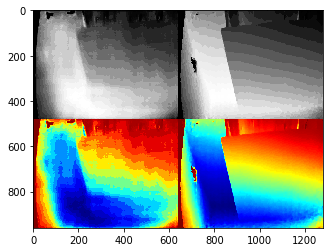

True

In [16]:
%matplotlib inline
plt.imshow(cv2.cvtColor(x[0], cv2.COLOR_BGR2RGB))
plt.show()
cv2.imwrite('prediction.jpg', x[0])

In [19]:
model = load_model('/home/julien/Dokumente/Beleg/calculations/model.h5')

In [20]:
c = cv2.imread('/home/julien/Dokumente/Beleg/predict/Color/1.jpg', cv2.IMREAD_COLOR)
c = cv2.cvtColor(c, cv2.COLOR_BGR2RGB)
print(c.shape)
c = (c/255).astype(np.float32)
i = cv2.imread('/home/julien/Dokumente/Beleg/predict/Infrared/1.png', cv2.IMREAD_ANYDEPTH)
print(i.shape)
i = (i/65535).astype(np.float32)



(480, 640, 3)
(480, 640)


In [21]:
y = model.predict([c.reshape(1,480,640,3), i.reshape(1,480,640,1)])

In [22]:
print(y.dtype)
print(y.shape)

float32
(1, 480, 640, 1)


In [23]:
print(y)

[[[[ 207.80609 ]
   [ 273.73483 ]
   [ 189.12093 ]
   ...
   [ 599.5846  ]
   [ 550.18097 ]
   [ 342.4792  ]]

  [[ 306.40836 ]
   [ 396.53366 ]
   [ 280.3085  ]
   ...
   [ 451.09375 ]
   [ 450.67078 ]
   [ 297.7973  ]]

  [[  69.882034]
   [ 157.48546 ]
   [ 188.91634 ]
   ...
   [ 765.8327  ]
   [ 405.687   ]
   [ 187.9987  ]]

  ...

  [[ 118.31966 ]
   [ 181.48906 ]
   [ 247.37285 ]
   ...
   [3005.4673  ]
   [1811.4524  ]
   [ 751.4243  ]]

  [[ -76.50899 ]
   [  -6.790967]
   [ 159.09459 ]
   ...
   [2526.9233  ]
   [1410.2195  ]
   [ 466.56665 ]]

  [[  33.735035]
   [  74.64757 ]
   [ 143.45723 ]
   ...
   [1385.9131  ]
   [ 629.48706 ]
   [ 118.7318  ]]]]


In [ ]:
%matplotlib inline
plt.imshow(y.reshape(480,640), cmap="gray")
plt.show()